In [2]:
import numpy as np
import glob

from annoy import AnnoyIndex

import torch
import torch.nn as nn

from torchsummary import summary

import matplotlib.pyplot as plt

In [3]:
bbEmbeddingPath = "testrep/BubbleBobble"

In [4]:
columnRefArray = np.array([i+1 for i in range(13) for j in range(12)])

In [5]:
#bbEmbeddingPaths = sorted(glob.glob("testrep/BubbleBobble/level*.npy"))
bbEmbeddingPaths = sorted(glob.glob("/home/surfytom/Projects/Dissertation/Repos/TileEmbeddingDissertation/data/unified_rep/bubble_bobble/round*.pickle"))

In [6]:
import pickle

def get_pickle(pickle_path):
    '''
    This function loads the pickle file
    
    Input
    pickle_path: path of the pickle file
    Output
    Loads and returns the stored pickle file
    
    '''
    with open(pickle_path, "rb") as handle:
        level_pickle = pickle.load(handle)
    return level_pickle

In [7]:
N = 78

sosArray = np.ones(shape=(1, 256)) * 9
eosArray = np.ones(shape=(1, 256)) * 5

xTrain = []
xTrainHotColumnRef = []
yTrain = []
xTrainTargetIn = []

columnRef = []
for i, levelEmbeddingPath in enumerate(bbEmbeddingPaths[:100]):

    #levelEmbeddingArray = np.load(levelEmbeddingPath)
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]
        targetIn = np.concatenate((sosArray, dataT))
        targetOut = np.concatenate((dataT, eosArray))

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        columnRef.append(dataC)
        xTrain.append(dataI)
        xTrainTargetIn.append(targetIn)
        yTrain.append(targetOut)

xTrain = np.array(xTrain)
xTrainTargetIn = np.array(xTrainTargetIn)
yTrain = np.array(yTrain)
columnRef = np.array(columnRef)

In [49]:
class LSTMModel(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.histLSTM = nn.LSTM(78, 256)
        self.colLSTM = nn.LSTM(78, 256)

        self.textLSTM = nn.LSTM(79, 256)
        self.infTextLSTM = nn.LSTM(78, 256)

        self.outputLayer = nn.Linear(256, 79)

    def forward(self, xHist, xText, xCol):
        
        histOut, (histH, histC) = self.histLSTM(xHist)

        colOut, (colH, colC) = self.colLSTM(xCol)

        hiddenAdd = torch.add(histH, histC)
        channelAdd = torch.add(colH, colC)

        textOut, (textH, textC) = self.textLSTM(xText, (hiddenAdd, channelAdd)) if self.training else self.infTextLSTM(xText, (hiddenAdd, channelAdd))

        output = nn.functional.tanh(self.outputLayer(textOut))
        
        return output
    
    def eval(self):

        # Sets up the weights of the inference lstm layer for text input
        self.infTextLSTM._flat_weights[0] = self.textLSTM._flat_weights[0][:, :78].clone().detach()
        self.infTextLSTM._flat_weights[1:] = [weightArray.clone().detach() for weightArray in self.textLSTM._flat_weights[1:]]

        super().eval()
        self.train(False)

In [50]:
def TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[2], xTrain.shape[1])
    xTrainTargetIn = xTrainTargetIn.reshape(xTrainTargetIn.shape[0], xTrainTargetIn.shape[2], xTrainTargetIn.shape[1])
    yTrain = yTrain.reshape(yTrain.shape[0], yTrain.shape[2], yTrain.shape[1])
    columnRef = columnRef.reshape(columnRef.shape[0], columnRef.shape[2], columnRef.shape[1])

    for i in range(epochs):

        losses.append([])

        for j in range(0, xTrain.shape[0], batchSize):
            
            xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
            xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

            yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

            columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

            # print(xTrainTensor.shape)
            # print(xTrainTargetInTensor.shape)
            # print(yTrainTensor.shape)
            # print(columnRefTensor.shape)

            yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
            
            loss = criterion(yPred, yTrainTensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [54]:
model = TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, 10, 32)

Epoch 0: loss 0.471065503127616
Epoch 1: loss 0.3931133337318897
Epoch 2: loss 0.3883872194022968
Epoch 3: loss 0.3855278328831854
Epoch 4: loss 0.38438401461161414
Epoch 5: loss 0.38169620789844416
Epoch 6: loss 0.38030588318561687
Epoch 7: loss 0.3787160213908245
Epoch 8: loss 0.377454900150669
Epoch 9: loss 0.3763318678428387


In [55]:
total = 0
for name, param in model.named_parameters():
    print(f"{name:<24}: {param.numel():5}")
    total += param.numel()

print(f"Total Params: {total}")

histLSTM.weight_ih_l0   : 79872
histLSTM.weight_hh_l0   : 262144
histLSTM.bias_ih_l0     :  1024
histLSTM.bias_hh_l0     :  1024
colLSTM.weight_ih_l0    : 79872
colLSTM.weight_hh_l0    : 262144
colLSTM.bias_ih_l0      :  1024
colLSTM.bias_hh_l0      :  1024
textLSTM.weight_ih_l0   : 80896
textLSTM.weight_hh_l0   : 262144
textLSTM.bias_ih_l0     :  1024
textLSTM.bias_hh_l0     :  1024
infTextLSTM.weight_ih_l0: 79872
infTextLSTM.weight_hh_l0: 262144
infTextLSTM.bias_ih_l0  :  1024
infTextLSTM.bias_hh_l0  :  1024
outputLayer.weight      : 20224
outputLayer.bias        :    79
Total Params: 1397583


tileMap shape: (14820, 16, 16, 3)
embedMap shape: (14820, 256)
Maps Loaded
Initialised Tree
Building Tree
Tree Built
Annoy Map Trained
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model


/home/surfytom/miniconda3/envs/DissEnv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:911: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running Model
Input shape: (78, 78, 256)
input size: torch.Size([256, 78])
target shape: (78, 78, 256)
target size: torch.Size([256, 78])
column shape: (78, 78, 256)
column size: torch.Size([256, 78])
Running M

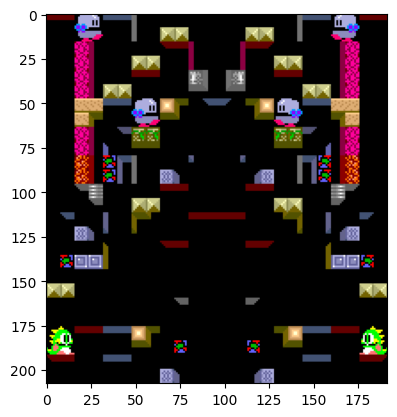

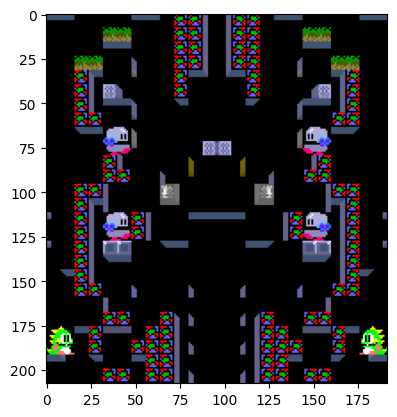

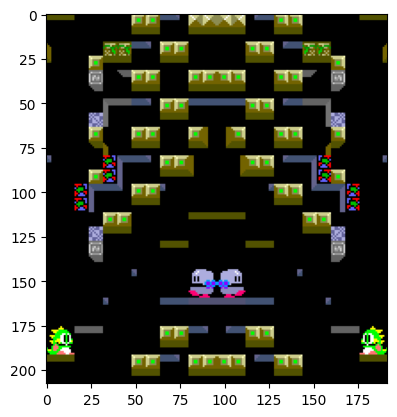

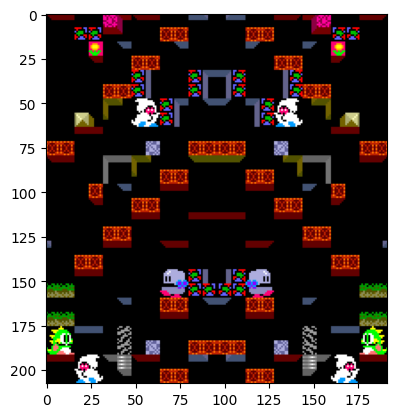

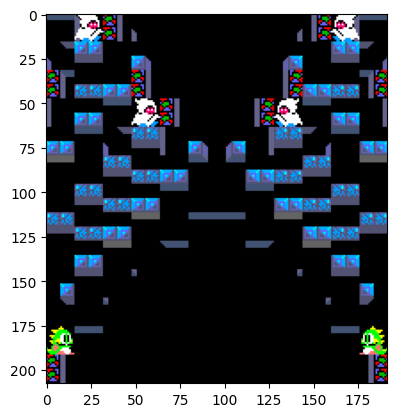

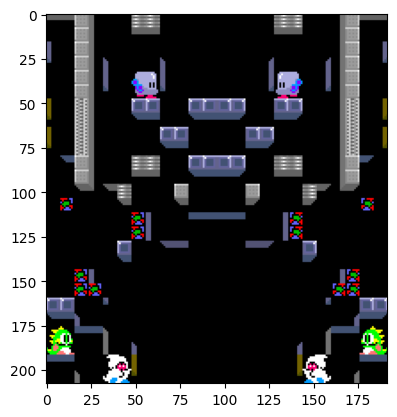

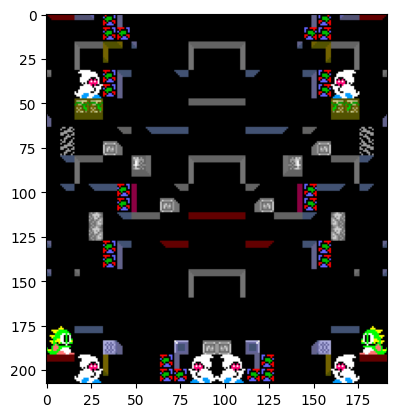

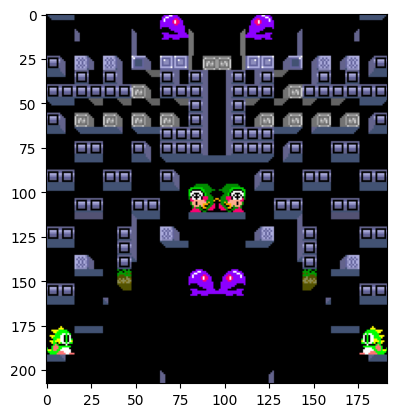

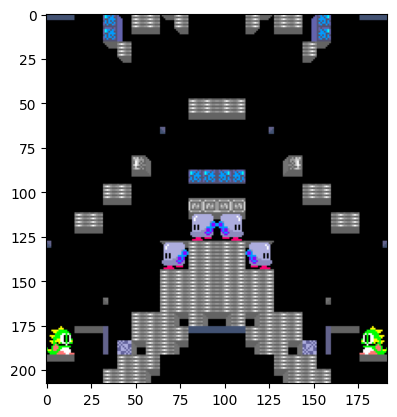

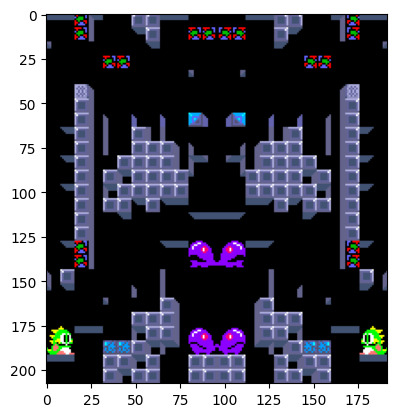

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

# tileMap = np.load("testrep/BubbleBobble/centerTiles.npy")
# embedMap = np.load("testrep/BubbleBobble/embeddings.npy")

tileMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2tile.pickle").values()))
embedMap = np.array(list(get_pickle("../data/unified_rep/bubble_bobble/"+"mappings/idx2embed.pickle").values()))

print(f"tileMap shape: {tileMap.shape}")
print(f"embedMap shape: {embedMap.shape}")

print("Maps Loaded")

nnTree = AnnoyIndex(256, 'euclidean')

print("Initialised Tree")

#for i in range(embedMap.shape[0]): print(f"Added {i}th item to tree"), nnTree.add_item(i, embedMap[i])
for i in range(embedMap.shape[0]): nnTree.add_item(i, embedMap[i])

print("Building Tree")
nnTree.build(15)
print("Tree Built")

print("Annoy Map Trained")

N = 78

NLevels = 10
for i, levelEmbeddingPath in enumerate(bbEmbeddingPaths[:NLevels]):

    input = []
    column = []
    target = []

    #levelEmbeddingArray = np.load(levelEmbeddingPath)
    levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    print(f"Input shape: {input.shape}")
    input = torch.tensor(input[0].reshape(256, N), dtype=torch.float32).to(device)
    print(f"input size: {input.size()}")

    target = np.array(target)
    print(f"target shape: {target.shape}")
    target = torch.tensor(target[0].reshape(256, N), dtype=torch.float32).to(device)
    print(f"target size: {target.size()}")

    column = np.array(column)
    print(f"column shape: {column.shape}")
    column = torch.tensor(column[0].reshape(256, N), dtype=torch.float32).to(device)
    print(f"column size: {column.size()}")

    print("Running Model")

    nextCol = model(input, target, column)
    nextCol = nextCol.cpu().detach().numpy()
    nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)

    levelImage = np.zeros(shape=(nextCol.shape[0] * 16, nextCol.shape[1] * 16, 3), dtype=np.uint8)

    for t, row in enumerate(nextCol):
        for j, embedding in enumerate(row):

            nearestEmbedding = nnTree.get_nns_by_vector(embedding, 2, search_k=-1, include_distances=False)[0]
            tileImage = tileMap[nearestEmbedding]

            levelImage[t*16 : t*16+16, j*16 : j*16+16, :] = tileImage

    levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(levelImage)